In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, LBFGS, AdamW
#!pip3 install adamp
from adamp import AdamP
from torch.optim import SGD
from tqdm import tqdm_notebook as tqdm
import numpy as np
import time
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import io

from nrLDPC import *
from communication import *


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
mat_file = torch.load('./constellations/qam.pt')
M =256

codebook = mat_file[f'bitmap_{M}QAM']
const = mat_file[f'qam_{M}']

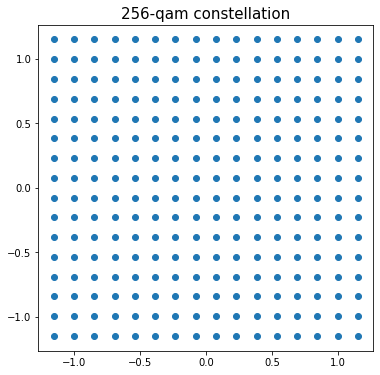

In [3]:
plt.figure(figsize=[6,6])
plt.title(f'{M}-qam constellation',fontsize=15)
plt.scatter(const[:,0],const[:,1])
plt.savefig(f'{M}QAM_constellation.png')

In [4]:
code_params={}
comm_params={}

"""
Z_c_list = [2, 4, 8, 16, 32, 64, 128, 256, ...
            3, 6, 12, 24, 48, 96, 192, 384, ...
            5, 10, 20, 40, 80, 160, 320, ...
            7, 14, 28, 56, 112, 224, ...
            9, 18, 36, 72, 144, 288, ...
            11, 22, 44, 88, 176, 352, ...
            13, 26, 52, 104, 208, ...
            15, 30, 60, 120, 240];
"""
code_params['Zc'] = 384
code_params['BG'] = 1
code_params['max_iter'] = 30
code_params['Decode_format'] = 'bits' #'llr'
code_params['channel_code_rate'] = '1/3'

comm_params['mod_type'] = 'qam' # bpsk
comm_params['mod_order'] = 64     # 4, 16, 64, 256



# 1/3 rate
EsdB_list = {4:torch.arange(-3, -1, 0.05),
             16:torch.arange(2, 4, 0.05),
             64:torch.arange(6, 8, 0.05),
             256:torch.arange(9, 11, 0.05)}

# # 2/3 rate
# EsdB_list = {4:torch.arange(2.5, 4.5, 0.05),
#              16:torch.arange(7.5, 9.5, 0.05),
#              64:torch.arange(12.5, 14.5, 0.05),
#              256:torch.arange(17.5, 19.5, 0.05)}

# #8/9 rate
# EsdB_list = {4:torch.arange(5, 7., 0.05),
#              16:torch.arange(12., 14., 0.05),
#              64:torch.arange(17.5, 19.5, 0.05),
#              256:torch.arange(22.5, 24.5, 0.05)}


snr_list = 10.0**(EsdB_list[comm_params['mod_order']]/10.0)
ldpc = nrLDPC(code_params, device)
comm = communication(comm_params, device)

cc_k = ldpc.cc_k
cc_n = ldpc.cc_n
cc_n_punctured = ldpc.cc_n_punctured
cc_rate = cc_k/cc_n_punctured


rate = cc_rate*np.log2(comm_params['mod_order'])

bits_pcu = np.log2(comm_params['mod_order'])




In [11]:
o = []
batch_size = 1000
num_batch = 10
q = [4, 16, 64, 256]
for order in tqdm(q):
    snr_list = 10.0**(EsdB_list[order]/10.0)
    BER = np.zeros(len(snr_list))
    comm_params['mod_order'] = order
    ldpc = nrLDPC(code_params, device)
    comm = communication(comm_params, device)
    
    for i, snr in enumerate(snr_list):
        data = gen_random_bits(batch_size, cc_k).to(device)   
        cw = ldpc.nrLDPC_encode(data)    
        x = comm.modulate(cw)    
        for j, bi in enumerate(np.arange(num_batch)):
            y = comm.AWGN(x, snr)
            llr = comm.demodulate(y, snr)
            xhat = ldpc.LDPC_decode(llr)
            bhat = xhat[:, 0: cc_k]
            BER[i] += torch.count_nonzero(torch.sum((data != bhat).type(torch.float32), axis=1))

        BER[i] = BER[i]/(num_batch*batch_size)
    o.append(BER)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.40s/it]


In [12]:
out = torch.tensor(o)

In [22]:
torch.save(out, "./rate.pt")

# Load pt

In [31]:
cr13 = torch.load('1_3 rate.pt')
cr23 = torch.load('2_3 rate.pt')
cr89 = torch.load('8_9 rate.pt')

In [32]:
# 1/3 rate
EsdB_list13 = {4:torch.arange(-3, -1, 0.05),
             16:torch.arange(2, 4, 0.05),
             64:torch.arange(6, 8, 0.05),
             256:torch.arange(9, 11, 0.05)}

# 2/3 rate
EsdB_list23 = {4:torch.arange(2.5, 4.5, 0.05),
             16:torch.arange(7.5, 9.5, 0.05),
             64:torch.arange(12.5, 14.5, 0.05),
             256:torch.arange(17.5, 19.5, 0.05)}

#8/9 rate
EsdB_list89 = {4:torch.arange(5, 7., 0.05),
             16:torch.arange(12., 14., 0.05),
             64:torch.arange(17.5, 19.5, 0.05),
             256:torch.arange(22.5, 24.5, 0.05)}

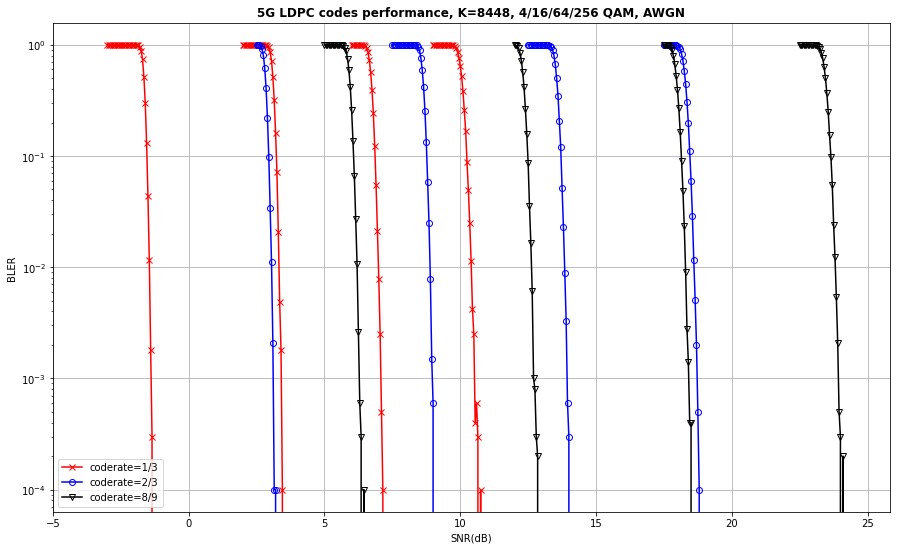

In [49]:

plt.figure(figsize=(15,9), facecolor='white')

plt.semilogy(EsdB_list13[4], cr13[0],'rx-', mfc='none')
plt.semilogy(EsdB_list23[4], cr23[0],'bo-', mfc='none')
plt.semilogy(EsdB_list89[4], cr89[0],'kv-', mfc='none')

plt.semilogy(EsdB_list13[16], cr13[1],'rx-', mfc='none')
plt.semilogy(EsdB_list13[64], cr13[2],'rx-', mfc='none')
plt.semilogy(EsdB_list13[256], cr13[3],'rx-', mfc='none')


plt.semilogy(EsdB_list23[16], cr23[1],'bo-', mfc='none')
plt.semilogy(EsdB_list23[64], cr23[2],'bo-', mfc='none')
plt.semilogy(EsdB_list23[256], cr23[3],'bo-', mfc='none')


plt.semilogy(EsdB_list89[16], cr89[1],'kv-', mfc='none')
plt.semilogy(EsdB_list89[64], cr89[2],'kv-', mfc='none')
plt.semilogy(EsdB_list89[256], cr89[3],'kv-', mfc='none')


plt.legend(['coderate=1/3', 'coderate=2/3', 'coderate=8/9']) 
plt.grid()
plt.xlabel('SNR(dB)')
plt.ylabel('BLER')
plt.xticks([-5, 0, 5, 10, 15, 20, 25])
plt.yticks([10**0, 10**(-1), 10**(-2), 10**(-3), 10**(-4)])
plt.title("5G LDPC codes performance, K=8448, 4/16/64/256 QAM, AWGN", fontweight="bold")
plt.savefig('nrLDPC_performance_plt.png')